# Malaria challenge trial calibration

### A history matching approach to calibrating an empirical model of malaria infection and immunity
### For iter0 we will cut down parameter space by using the distribution of infection durations by age in the KND cohort in Navrongo, Ghana

# Import block

In [6]:
from IPython.extensions import autoreload
%load_ext autoreload
%autoreload 2
import os, glob, re, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from wand.image import Image as WImage
from IPython.display import IFrame, display

from pyDOE import lhs
from history_matching import HistoryMatching, HistoryMatchingCut, quick_read, Basis

sns.set(font_scale=2)
sns.set_style("white")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def fix_glob(pth):
    return re.sub('([\[\]])','[\\1]', pth)

# Configure parameters and data for history matching

In [4]:
age_bin = ['20.0-40.0']
cut_name = f'Duration for'
DROP_BIN_20 = True

# iteration = int(re.search(r'iter(\d+)', os.getcwd())) # Index of the current iteration
iteration = 0 
#list of exp_ids/folders that correspond to exp_ids from which our emulation will draw
exp_ids = ['8435ba1a-12b8-e911-a2c1-c4346bcb1555'] # TODO: only uses first for now, should loop
basedir = 'C:\git\Malaria-Uganda-PRISM'
datafile = os.path.join('..','reference data', 'Ghana_Durations.xlsx')

In [4]:
# The implausibility threshold determines how willing we are to retain regions
# of parameter space that are inconsistent with the underlying data. A higher
# threshold is more risk averse in that potentially good regions are less likely
# to be rejected, however it will take more iterations/simulations to achieve results.
implausibility_threshold = 3
training_fraction = 0.75 # Fraction of simulations to use as training
discrepancy_std = 0.0 # Accounts for uncertainty w.r.t model structure
n_samples_to_generate_for_next_iter = 1000 # Number of simulations to conduct on this iteration

In [5]:
# Here we define the parameter names and ranges
params_file = os.path.join('..','Params.xlsx')
param_info = quick_read(params_file, 'Params').set_index('Name')
param_names = param_info.index.tolist()

params = param_info.index.values
n_params = param_info.shape[0] # We'll use this one place later
display(param_info)

Reading Params from ..\Params_30e173dde396b60b2c51dddd38aba221.hd5


,Min,Max,MapTo
Name,,,
Gametocyte_Conversion_Draw_Mean,0,6,Gametocyte_Conversion_Draw_Mean
Gametocyte_Conversion_Draw_Std_Dev,0,1,Gametocyte_Conversion_Draw_Std_Dev
Biological_Age_Immune_Coefficient_PPP,0,3,Biological_Age_Immune_Coefficient_PPP
Biological_Age_Immune_Coefficient_TM,-1,1,Biological_Age_Immune_Coefficient_TM
Cumulative_Exposure_Immune_Coefficient_PPP,0,3,Cumulative_Exposure_Immune_Coefficient_PPP
Cumulative_Exposure_Immune_Coefficient_TM,-1,1,Cumulative_Exposure_Immune_Coefficient_TM
Malaria_Free_Interval_Immune_Coefficient_PPP,0,3,Malaria_Free_Interval_Immune_Coefficient_PPP
Malaria_Free_Interval_Immune_Coefficient_TM,-1,1,Malaria_Free_Interval_Immune_Coefficient_TM
Recent_Exposure_Immune_Coefficient_PPP,0,3,Recent_Exposure_Immune_Coefficient_PPP


## Read in Sim Results

In [5]:
all_samples = []
all_results = []
for exp_id in exp_ids:
    
    print('-'*80, '\nExperiment:', exp_id)
    sim_results_fn = os.path.join(exp_id, 'analyzer_results.csv')
    print(sim_results_fn)
    sr = pd.read_csv(sim_results_fn, skipinitialspace=True)
    sr['Sample_Id'] = sr['sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    sr.rename(columns = {'sim_id': 'Sim_Id','age_cat': 'AgeBin','value':'Result'}, inplace=True)
    all_results.append( sr )
    #read in tags making a samples.xlsx file 
    s = pd.read_excel(os.path.join(exp_id, 'Samples.xlsx'))
    # s.drop('Sim_Id', axis=1, inplace=True)
    s['Sample_Id'] = s['Sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    all_samples.append( s )

#.rename(columns={'level_1': 'Year', 0: 'Cases'}) \
all_results = pd.concat(all_results) \
    .set_index(['Sample_Id', 'Sim_Id', 'AgeBin']) \
    [['Result']] \
    .sort_index()

samples = pd.concat(all_samples).set_index('Sample_Id').sort_index() # Bad because sample will be repeated across exp_id!
                       
samples.to_csv('Samples.csv')
all_results.to_csv('Results_by_age.csv')
results = all_results['Result']

results = all_results[ 
        
        (all_results.index.get_level_values('AgeBin').isin(age_bin))
    ] \
    .groupby(['Sample_Id', 'Sim_Id']) \
    .mean()

    
results.rename(columns={'Result':'Sim_Result'}, inplace=True)

display(results.head())

-------------------------------------------------------------------------------- 
Experiment: 8435ba1a-12b8-e911-a2c1-c4346bcb1555
C:\git\Malaria-Uganda-PRISM\v0-challengeTrial\iter0\8435ba1a-12b8-e911-a2c1-c4346bcb1555\analyzer_results.csv


,,Sim_Result
Sample_Id,Sim_Id,
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000000,532f0527-12b8-e911-a2c1-c4346bcb1555,62.929000
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000001,542f0527-12b8-e911-a2c1-c4346bcb1555,61.925926
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000002,552f0527-12b8-e911-a2c1-c4346bcb1555,61.243000
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000003,562f0527-12b8-e911-a2c1-c4346bcb1555,62.872000
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000004,572f0527-12b8-e911-a2c1-c4346bcb1555,62.514000


In [7]:
ref_data_path = os.path.join('..','reference data','GhanaDurations.xlsx')
ref_df = pd.read_excel(ref_data_path)

# how to set the cwd


desired_result_ref_age = ref_df.loc[ref_df['Age bin'] == int(age_bin[0][:2])]
desired_result = desired_result_ref_age['Mean']
desired_result_std = (desired_result_ref_age['CI_upper']-desired_result_ref_age['CI_lower'])/(2*1.96)

desired_result = desired_result.values[[0]].item()
desired_result_std = desired_result_std.values[[0]].item()

print('Before logit, desired result is %.3f [%.3f, %.3f]: ' % (desired_result, desired_result-2*desired_result_std, desired_result+2*desired_result_std))


Before logit, desired result is 129.000 [123.898, 134.102]: 


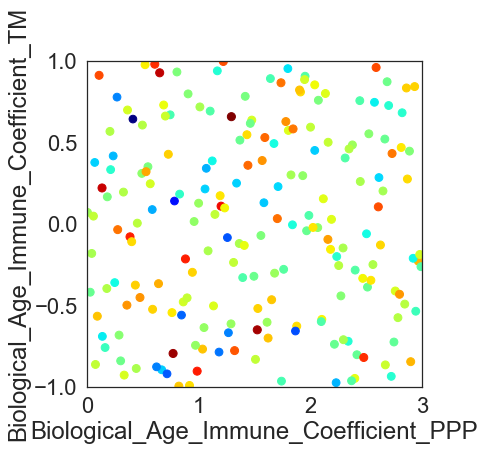

In [8]:
z = pd.merge(samples, results, on='Sample_Id') # Return to Sample_Id

#sub in variables here, can be list of tuples
xyvars = [('Biological_Age_Immune_Coefficient_PPP',	'Biological_Age_Immune_Coefficient_TM'
)]
for (xvar, yvar) in xyvars:
    fig = plt.figure(figsize=(6,6))
    plt.scatter(z[xvar], z[yvar], c=100*z['Sim_Result'], s=1*z['Sim_Result'], cmap='jet')
    plt.xlabel(xvar); plt.ylabel(yvar)
    plt.xlim([param_info.loc[xvar, 'Min'], param_info.loc[xvar, 'Max']])
    plt.ylim([param_info.loc[yvar, 'Min'], param_info.loc[yvar, 'Max']])
    # TODO: Show as surface and plot desired result as isocline
plt.show()

In [9]:
# Finally we get to do some History Matching!
# Begin by creating an instance of the HistoryMatching class
ext = 'svg' # Filetype for figures produced by history matching
hm = HistoryMatching(
    cut_name = cut_name,
    param_info = param_info,
    inputs = samples,
    results = results.squeeze(),
    desired_result = desired_result,
    desired_result_var = desired_result_std**2,
    iteration = iteration,
    implausibility_threshold = implausibility_threshold,
    discrepancy_var = discrepancy_std**2,
    training_fraction = training_fraction,
    fig_type = ext
)
hm.save() # Save to disk

Welcome to IDM History Matching!
Found 200 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 150 unique parameter configurations ( 150  simulations including replicates)
--> Testing  with 50  unique parameter configurations ( 50 simulations including replicates)


In [10]:
try:
    existing_basis = True
    need_basis = True
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json')) as data_file:
        config = json.load( data_file )
        basis_glm = Basis.deserialize(config['Basis'])
        fitted_values = pd.read_json(config['Fitted_Values'], orient='split').set_index(['Sample_Id', 'Sim_Id']).squeeze()
except:
    existing_basis = False
    
if existing_basis:
    print('Found existing GLM basis with the following terms:')
    display(basis_glm.model_terms)
    reply = input('Would you like to use this basis? [Y]/n: ')
    
    if reply.lower() != 'n':
        need_basis = False
    
if need_basis:
    basis_glm = Basis.polynomial_basis(params=param_names, intercept = True, first_order=True, second_order=True, third_order=False, param_info=param_info)

#     basis_glm.plot_regularize(samples, results, alpha = np.logspace(-5, -2, 15), scaleX=True)
    alpha_glm = float(input('What would you like to use for the GLM regularization parameter, alpha_glm = '))
#     alpha_glm = 1e-1
    
    fitted_values = basis_glm.regularize(samples, results, alpha = alpha_glm, scaleX=True)
    print('Regularization for GLM selected:\n', ' *','\n * '.join(basis_glm.get_terms()))
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json'), 'w') as fout:
        json.dump( {
            'Basis': basis_glm.serialize(),
            'Fitted_Values': fitted_values.reset_index().to_json(orient='split')
        }, fout, indent=4)

Found existing GLM basis with the following terms:


[Term([]),
 Term([EvalFactor('Biological_Age_Immune_Coefficient_PPP')]),
 Term([EvalFactor('Scale_Factor_Age_b')]),
 Term([EvalFactor('Scale_Factor_Free_Interval_a')]),
 Term([EvalFactor('Recent_Exposure_Immune_Coefficient_PPP * Scale_Factor_Age_a')]),
 Term([EvalFactor('Recent_Exposure_Immune_Coefficient_TM * Wave_Vs_Infection_Relative_Weight')]),
 Term([EvalFactor('Scale_Factor_Free_Interval_a * Wave_Vs_Infection_Relative_Weight')])]

Would you like to use this basis? [Y]/n: Y


In [11]:
# Now fit the glm and plot

### GLM ###############################################################
print("="*80, "\nGeneralized Linear Modeling\n", "="*80)
#######################################################################
f = hm.glm(
    basis = basis_glm,
    family = 'Poisson',
    force_optimize_glm = True,
    glm_fit_maxiter = 100000,
    plot = True, #force_optimize_glm,
    plot_data = False
)

Generalized Linear Modeling
Plotting


In [12]:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [13]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "GLM Predicted vs Actual*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

..\iter0\Cuts\Duration for\GLM\GLM Predicted vs Actual.svg


In [14]:
basis_gpr = Basis.polynomial_basis(
    params =  ['Scale_Factor_Age_a', 'Scale_Factor_Age_b'],
    #params = param_info.index.values, #
    intercept = False, 
    first_order = True, 
    param_info=param_info)

In [15]:

### GPR ###############################################################
print("="*80, "\nGaussian Process Regression\n", "="*80)
#######################################################################
hm.gpr(
    basis = basis_gpr,
    force_optimize_gpr = True,

    sigma2_f_guess = 0.6,
    sigma2_f_bounds = (0.1, 1000),
    sigma2_n_guess =  2.0,
    sigma2_n_bounds = (0.01, 100),

    #lengthscale_guess = [0.09844299, 0.1256657, 0.0976875, 0.09889085, 0.1051974, 0.0950809, 0.10032171, 0.10599185, 0.10627393, 0.09950996, 0.09445544, 0.10285915, 0.10007409, 0.09847433, 0.08963389, 0.10205652, 0.09360044, 0.1024141, 0.09786228, 0.10247492, 0.09852253, 0.09632744, 0.09997534, 0.10767302, 0.10095249, 0.09941825, 0.10214923, 0.10221497, 0.09734157, 0.09093285, 0.10780673, 0.09881377, 0.10597152],
    lengthscale_guess = 0.25,
    lengthscale_bounds = (0.01, 100),

    optimize_sigma2_n = True,
    log_transform = False,

    verbose = True,
    optimizer_options = {
        'eps': 5e-3,
        'disp': True,
        'maxiter': 15000,
        'ftol': 2 * np.finfo(float).eps,
        'gtol': 2 * np.finfo(float).eps,
    },
    plot = True, #force_optimize_gpr,
    plot_data = False
)

Gaussian Process Regression
Autoinit GPU device name: GeForce GTX 965M
Backing up gpr model to ..\iter0\Cuts\Duration for\GPR\model_2019_08_06_10_29_53.json
Fitting the GPR

	LL: 229.8976886811541 
	Theta: [0.6  2.   0.25 0.25] 
	Deriv: [ 1.04552899 18.37463528 -0.09460694 -2.85606195]

	LL: 7260.519713084417 
	Theta: [0.1        0.01       0.34460694 3.10606195] 
	Deriv: [ 9.97626978e+00 -7.39093117e+05  7.59507869e+01 -9.33438764e-01]

	LL: 217.4664783904794 
	Theta: [0.43333957 1.33669148 0.28153447 1.20198503] 
	Deriv: [ 0.72981268 13.94008879  0.8579876  -0.35743783]

	LL: 7285.821844135344 
	Theta: [0.21787384 0.01       0.01       1.5013367 ] 
	Deriv: [ 3.26141359e+01 -7.41236428e+05  2.47800536e+04 -1.99358306e+00]

	LL: 214.8977874839021 
	Theta: [0.36190111 0.89682199 0.19150621 1.30123619] 
	Deriv: [ 1.21245551 -9.56616194  1.3997392  -0.38564193]

	LL: 214.60842149359297 
	Theta: [0.36622677 1.06561862 0.20773336 1.30330254] 
	Deriv: [ 1.08040245  4.2757097   1.17934788 -0.


	LL: 212.91071393138833 
	Theta: [1.00000000e-01 9.83695809e-01 4.46826389e-02 1.00000000e+02] 
	Deriv: [ 2.95283790e+00  4.62452790e-04 -7.05448181e-04 -1.01671450e-04]

	LL: 212.91071472942576 
	Theta: [1.00000000e-01 9.83784680e-01 4.46799151e-02 1.00000000e+02] 
	Deriv: [ 2.95304283e+00  7.31521101e-03 -1.78708555e-03 -1.01657950e-04]

	LL: 212.91071342996855 
	Theta: [1.00000000e-01 9.83796111e-01 4.46795647e-02 1.00000000e+02] 
	Deriv: [ 2.95309125e+00  8.19850216e-03 -1.92619627e-03 -1.01656242e-04]

	LL: 212.91071316795018 
	Theta: [1.00000000e-01 9.83796222e-01 4.46795613e-02 1.00000000e+02] 
	Deriv: [ 2.95308309e+00  8.20808889e-03 -1.92152106e-03 -1.01656229e-04]

	LL: 212.91071315796867 
	Theta: [1.00000000e-01 9.83796222e-01 4.46795613e-02 1.00000000e+02] 
	Deriv: [ 2.95308274e+00  8.20810908e-03 -1.92215746e-03 -1.01656229e-04]

	LL: 212.91071315796867 
	Theta: [1.00000000e-01 9.83796222e-01 4.46795613e-02 1.00000000e+02] 
	Deriv: [ 2.95308274e+00  8.20810908e-03 -1.9221


	LL: 212.91071290369723 
	Theta: [1.00000000e-01 9.83710353e-01 4.46996697e-02 1.00000000e+02] 
	Deriv: [ 2.95084965e+00  1.60499805e-03  6.81992723e-03 -1.01673956e-04]

	LL: 212.91071290369723 
	Theta: [1.00000000e-01 9.83710353e-01 4.46996697e-02 1.00000000e+02] 
	Deriv: [ 2.95084965e+00  1.60499805e-03  6.81992723e-03 -1.01673956e-04]

	LL: 212.91071291412214 
	Theta: [1.00000000e-01 9.83710353e-01 4.46996696e-02 1.00000000e+02] 
	Deriv: [ 2.95084758e+00  1.60497866e-03  6.82136019e-03 -1.01673956e-04]

	LL: 212.91071290369723 
	Theta: [1.00000000e-01 9.83710353e-01 4.46996697e-02 1.00000000e+02] 
	Deriv: [ 2.95084965e+00  1.60499805e-03  6.81992723e-03 -1.01673956e-04]

	LL: 212.91071290369723 
	Theta: [1.00000000e-01 9.83710353e-01 4.46996697e-02 1.00000000e+02] 
	Deriv: [ 2.95084965e+00  1.60499805e-03  6.81992723e-03 -1.01673956e-04]

	LL: 212.9107128848516 
	Theta: [1.00000000e-01 9.83710353e-01 4.46996697e-02 1.00000000e+02] 
	Deriv: [ 2.95084974e+00  1.60503344e-03  6.82038


	LL: 212.92322019810638 
	Theta: [1.00000000e-01 9.82104563e-01 3.78830606e-02 1.00000000e+02] 
	Deriv: [ 3.85384868e+00 -1.45645317e-01 -4.01030473e+00 -9.98833773e-05]

	LL: 212.9107136633602 
	Theta: [1.00000000e-01 9.83706827e-01 4.46847015e-02 1.00000000e+02] 
	Deriv: [ 2.95258633e+00  1.32015673e-03  2.24955057e-04 -1.01670424e-04]

	LL: 212.91071290092694 
	Theta: [1.00000000e-01 9.83710299e-01 4.46994403e-02 1.00000000e+02] 
	Deriv: [ 2.95087752e+00  1.60420582e-03  6.73547871e-03 -1.01673883e-04]

	LL: 212.91071267927217 
	Theta: [1.00000000e-01 9.83710352e-01 4.46996658e-02 1.00000000e+02] 
	Deriv: [ 2.95086868e+00  1.60548160e-03  6.82365674e-03 -1.01673955e-04]

	LL: 212.91071252964264 
	Theta: [1.00000000e-01 9.83710352e-01 4.46996660e-02 1.00000000e+02] 
	Deriv: [ 2.95086981e+00  1.60578938e-03  6.81660538e-03 -1.01673956e-04]

	LL: 212.91071252964264 
	Theta: [1.00000000e-01 9.83710352e-01 4.46996660e-02 1.00000000e+02] 
	Deriv: [ 2.95086981e+00  1.60578938e-03  6.81660

In [16]:
pi = param_info.loc[basis_gpr.param_dict.keys()].reset_index()
pi['Lengthscale'] = hm.gpr_model.theta[2:]
print(pi[['Name', 'Lengthscale']].sort_values('Lengthscale'))

                 Name  Lengthscale
0  Scale_Factor_Age_a       0.0447
1  Scale_Factor_Age_b     100.0000


In [17]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.gprdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [18]:
### Implausibility ############################################################
print("="*80, "\nImplausibility\n", "="*80)
###############################################################################
hm.calc_and_plot_implausibility(
    plot = True,
    do_plot_data = False,
    plot_data_highlight = pd.DataFrame() #hm.test_data.loc['prime.000049']
) 
    #plot_data_highlight=pd.DataFrame() # plot_data_highlight=hm.training_data.loc['prime.000049']

hm.training_data.to_excel(os.path.join('Cuts', cut_name, 'train_data.xlsx'))
hm.test_data.to_excel(os.path.join('Cuts', cut_name, 'test_data.xlsx'))

print('Good')

Implausibility
Good


In [19]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.combineddir, "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

..\iter0\Cuts\Duration for\Implausibility\implausibility.svg


   Age bin  Mean  CI_lower  CI_upper
0       20   129       124       134
                                                AgeBin     Result
Sample_Id                                                        
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000000  20.0-40.0  62.929000
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000001  20.0-40.0  61.925926
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000002  20.0-40.0  61.243000
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000003  20.0-40.0  62.872000
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000004  20.0-40.0  62.514000
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000005  20.0-40.0  63.370000
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000006  20.0-40.0  61.191000
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000007  20.0-40.0  61.282000
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000008  20.0-40.0  61.986000
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000009  20.0-40.0  62.750000
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000010  20.0-40.0  60.417417
8435ba1a-12b8-e911-a2c1-c4346bcb1555.000011  20.0-40.0  62.644000
84

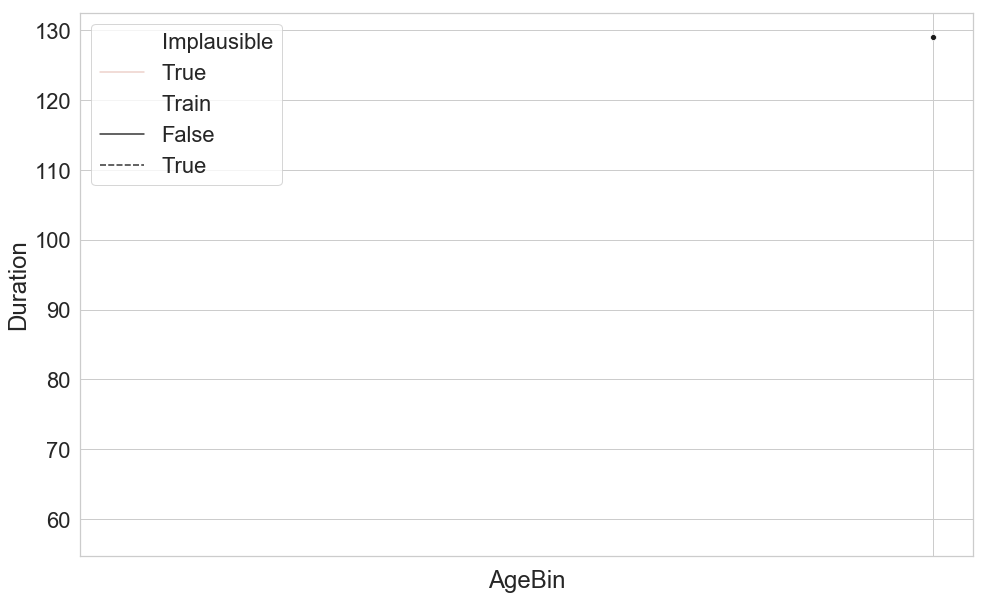

In [34]:
ar = all_results.reset_index()

data = ar.loc[ar['AgeBin']==age_bin[0]].groupby(['Sample_Id','AgeBin'])['Result'].mean().reset_index().set_index('Sample_Id')

train = hm.training_data
train['Train'] = True
test = hm.test_data
test['Train'] = False
train_test = pd.concat([train, test])

fig, ax = plt.subplots(figsize=(16,10))

# Reference
#ref_by_year = reference_data[['Prevalence']].reset_index()

ref_by_year = ref_df.loc[ref_df['Age bin'] == int(age_bin[0][:2])] \
    .groupby('Age bin') \
    .mean() \
    .reset_index()
print(ref_by_year)
print(data)
sns.lineplot(data=ref_by_year, x='Age bin', y='Mean', color='k', marker='o', alpha=1, lw=2, zorder=1);

# Sims
tmp = data.merge(train_test[['Sample_Orig', 'Implausible', 'Train']], left_on='Sample_Id', right_on='Sample_Orig')
print(tmp.head())
sns.lineplot(data=tmp, x='AgeBin', y='Result', hue='Implausible', style='Train', 
             units='Sample_Orig', estimator=None, alpha=0.5, lw=0.5,
             ax=ax, zorder=-1)
ax.set_xlabel('AgeBin');
ax.set_ylabel('Duration');
ax.set_xticks(ref_by_year['Age bin'].unique());